Testando dois classifcadores: KNN (k=3 e k=5) e Distância Mínima de Centróide.

Utilizamos as bases de dados Iris e dermatology.

Os classificadores serão testados por 50 rodadas independentes.

Para exibir resultados, imprimimos uma tábela contendo a média e o desvio padrão das acurácias. Também exibimos uma matriz de confusão média.

In [8]:
# Bibliotecas
import numpy as np

In [9]:
NUM_ROUNDS = 50

## Definição dos modelos

A distância euclidiana será utilizada nos dois modelos.

In [10]:
def euclidian_distance(x1, x2):
  return np.sqrt(np.sum((x1 - x2) ** 2))

In [59]:
class KNearestNeighbors:
  def __init__(self, n_neighbors=5):
    self.n_neighbors = n_neighbors

  def fit(self, X, y):
    self.X_train = X
    self.y_train = y

  def predict(self, X_test):
    preds = []

    for x_test in X_test:
      distances = [euclidian_distance(x_test, x_train) for x_train in self.X_train]

      k_nearest_indices = np.argsort(distances)[:self.n_neighbors]
      k_nearest_labels = [self.y_train[i] for i in k_nearest_indices]

      unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
      most_common_label = unique_labels[np.argmax(counts)]

      preds.append(most_common_label)

    return np.array(preds)

class DMC:
  def __init__(self):
    self.centroids = {}
    self.class_counts = {}

  def fit(self, X, y):
    unique_classes = np.unique(y)

    for cls in unique_classes:
      X_class = X[y == cls]
      self.centroids[cls] = np.median(X_class, axis=0)
      self.class_counts[cls] = len(X_class)

    '''
    print('\nCentróides iniciais calculados:')
    for cls, centroid in self.centroids.items():
      print(f'Classe {cls}: centroid')
    '''

  def predict(self, X_test):
    preds = []

    for i, x_test in enumerate(X_test):
      distances = []
      for cls, centroid in self.centroids.items():
        dist = euclidian_distance(x_test, centroid)
        distances.append((dist, cls))
      distances.sort()
      closest_class = distances[0][1]
      preds.append(closest_class)

      # Atualização do centroide
      current_class = self.class_counts[closest_class]
      new_class = current_class + 1
      alpha = 1 / new_class
      self.centroids[closest_class] = (1 - alpha) * self.centroids[closest_class]
      self.class_counts[closest_class] = new_class

      # print(f'Teste {i+1} ({x_test}) foi classificado como {closest_class}')

    return np.array(preds)

# Datasets

Instalando a biblioteca do UCI Datasets para baixar os datasets.

In [36]:
!pip install ucimlrepo --quiet

In [37]:
from ucimlrepo import fetch_ucirepo

In [80]:
def train_test_split(X, y, test_size=0.2, random_state=None):
  if random_state is not None:
      np.random.seed(random_state)

  n_samples = len(X)
  shuffled_indices = np.random.permutation(n_samples)
  n_test_samples = int(n_samples * test_size)
  test_indices = shuffled_indices[:n_test_samples]
  train_indices = shuffled_indices[n_test_samples:]

  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]

  return X_train, X_test, y_train, y_test

# Métricas

In [81]:
def accuracy(y_true, y_pred):
  return np.sum(y_true == y_pred) / len(y_true)

In [82]:
def confusion_matrix(y_true, y_pred, all_classes):
    num_classes = len(all_classes)
    class_to_idx = {cls: i for i, cls in enumerate(all_classes)}

    y_true_mapped = y_true.astype(type(all_classes[0]))
    y_pred_mapped = y_pred.astype(type(all_classes[0]))

    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for true_label, pred_label in zip(y_true_mapped, y_pred_mapped):
        if true_label in class_to_idx and pred_label in class_to_idx:
            true_idx = class_to_idx[true_label]
            pred_idx = class_to_idx[pred_label]
            conf_matrix[true_idx, pred_idx] += 1

    return conf_matrix

# Teste com o Iris

Download do dataset

In [83]:
iris = fetch_ucirepo(id=53)

X = iris.data.features.values
y = iris.data.targets.values.ravel()

iris_class_labels = np.unique(y)
iris_class_names = [name.replace('Iris-', '') for name in iris_class_labels]

Teste com as rodadas independentes

In [84]:
iris_knn_3_accuracies = []
iris_knn_5_accuracies = []
iris_dmc_accuracies = []

iris_knn_3_conf_matrices = []
iris_knn_5_conf_matrices = []
iris_dmc_conf_matrices = []

for i in range(NUM_ROUNDS):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

  knn_3 = KNearestNeighbors(n_neighbors=3)
  knn_3.fit(X_train, y_train)
  y_pred_knn3 = knn_3.predict(X_test)
  iris_knn_3_accuracies.append(accuracy(y_test, y_pred_knn3))
  iris_knn_3_conf_matrices.append(confusion_matrix(y_test, y_pred_knn3, iris_class_labels))

  knn_5 = KNearestNeighbors(n_neighbors=5)
  knn_5.fit(X_train, y_train)
  y_pred_knn5 = knn_5.predict(X_test)
  iris_knn_5_accuracies.append(accuracy(y_test, y_pred_knn5))
  iris_knn_5_conf_matrices.append(confusion_matrix(y_test, y_pred_knn5, iris_class_labels))

  dmc = DMC()
  dmc.fit(X_train, y_train)
  y_pred_dmc = dmc.predict(X_test)
  iris_dmc_accuracies.append(accuracy(y_test, y_pred_dmc))
  iris_dmc_conf_matrices.append(confusion_matrix(y_test, y_pred_dmc, iris_class_labels))


In [85]:
iris_knn_3_accuracy_mean = np.mean(iris_knn_3_accuracies)
iris_knn_3_std = np.std(iris_knn_3_accuracies)

iris_knn_5_accuracy_mean = np.mean(iris_knn_5_accuracies)
iris_knn_5_std = np.std(iris_knn_5_accuracies)

iris_dmc_accuracy_mean = np.mean(iris_dmc_accuracies)
iris_dmc_std = np.std(iris_dmc_accuracies)

In [86]:
iris_knn_3_mean_conf_matrix = np.mean(iris_knn_3_conf_matrices, axis=0)
iris_knn_5_mean_conf_matrix = np.mean(iris_knn_5_conf_matrices, axis=0)
iris_dmc_mean_conf_matrix = np.mean(iris_dmc_conf_matrices, axis=0)

# Teste com dermatology

In [87]:
dermatology = fetch_ucirepo(id=33)

X = dermatology.data.features
y = dermatology.data.targets.values.ravel()

dermatology_class_labels = np.unique(y)
dermatology_class_names = [
    'psoriasis', 'seboreic dermatitis', 'lichen planus',
    'pityriasis rosea', 'cronic dermatitis', 'pityriasis rubra pilaris'
]

Normalização do dataset e tratamento de NaN

In [88]:
X.loc[:, 'age'] = X['age'].fillna(X['age'].mean())

In [89]:
X = (X - X.min()) / (X.max() - X.min())

Teste com as rodadas independentes

In [90]:
dermatology_knn_3_accuracies = []
dermatology_knn_5_accuracies = []
dermatology_dmc_accuracies = []

dermatology_knn_3_conf_matrices = []
dermatology_knn_5_conf_matrices = []
dermatology_dmc_conf_matrices = []

for i in range(NUM_ROUNDS):
  X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=i)

  knn_3 = KNearestNeighbors(n_neighbors=3)
  knn_3.fit(X_train, y_train)
  y_pred_knn3 = knn_3.predict(X_test)
  dermatology_knn_3_accuracies.append(accuracy(y_test, y_pred_knn3))
  dermatology_knn_3_conf_matrices.append(confusion_matrix(y_test, y_pred_knn3, dermatology_class_labels))

  knn_5 = KNearestNeighbors(n_neighbors=5)
  knn_5.fit(X_train, y_train)
  y_pred_knn5 = knn_5.predict(X_test)
  dermatology_knn_5_accuracies.append(accuracy(y_test, y_pred_knn5))
  dermatology_knn_5_conf_matrices.append(confusion_matrix(y_test, y_pred_knn5, dermatology_class_labels))

  dmc = DMC()
  dmc.fit(X_train, y_train)
  y_pred_dmc = dmc.predict(X_test)
  dermatology_dmc_accuracies.append(accuracy(y_test, y_pred_dmc))
  dermatology_dmc_conf_matrices.append(confusion_matrix(y_test, y_pred_dmc, dermatology_class_labels))

Fazendo a média.

In [91]:
dermatology_knn_3_accuracy_mean = np.mean(dermatology_knn_3_accuracies)
dermatology_knn_3_std = np.std(dermatology_knn_3_accuracies)

dermatology_knn_5_accuracy_mean = np.mean(dermatology_knn_5_accuracies)
dermatology_knn_5_std = np.std(dermatology_knn_5_accuracies)

dermatology_dmc_accuracy_mean = np.mean(dermatology_dmc_accuracies),
dermatology_dmc_std = np.std(dermatology_dmc_accuracies)

In [92]:
dermatology_knn_3_mean_conf_matrix = np.mean(dermatology_knn_3_conf_matrices, axis=0)
dermatology_knn_5_mean_conf_matrix = np.mean(dermatology_knn_5_conf_matrices, axis=0)
dermatology_dmc_mean_conf_matrix = np.mean(dermatology_dmc_conf_matrices, axis=0)

# Resultados

In [93]:
import matplotlib.pyplot as plt
import seaborn as sn

## Tabela de acurácia

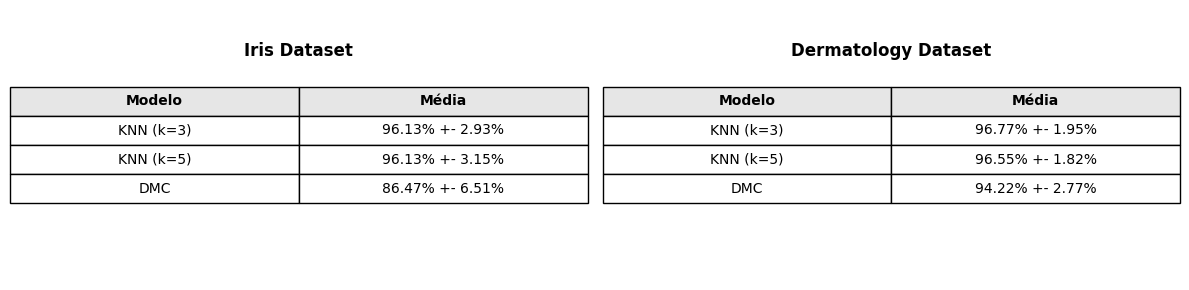

In [94]:
data_iris = [
    ["Modelo", "Média"],
    ['KNN (k=3)', f'{iris_knn_3_accuracy_mean*100:.2f}% +- {iris_knn_3_std*100:.2f}%'],
    ["KNN (k=5)", f"{iris_knn_5_accuracy_mean*100:.2f}% +- {iris_knn_5_std*100:.2f}%"],
    ["DMC", f"{iris_dmc_accuracy_mean*100:.2f}% +- {iris_dmc_std*100:.2f}%"]
]

data_dermatology = [
    ["Modelo", "Média"],
    ["KNN (k=3)", f"{dermatology_knn_3_accuracy_mean*100:.2f}% +- {dermatology_knn_3_std*100:.2f}%"],
    ["KNN (k=5)", f"{dermatology_knn_5_accuracy_mean*100:.2f}% +- {dermatology_knn_5_std*100:.2f}%"],
    ["DMC", f"{dermatology_dmc_accuracy_mean*100:.2f}% +- {dermatology_dmc_std*100:.2f}%"]
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

iris_table = ax1.table(cellText=data_iris, cellLoc='center', loc='center')
iris_table.scale(1, 1.5)
for (row, col), cell in iris_table.get_celld().items():
    if row == 0:
        cell.set_facecolor("#e6e6e6"); cell.set_text_props(weight='bold')
ax1.set_title("Iris Dataset", y=0.8, weight='bold')
ax1.axis('off');

dermatology_table = ax2.table(cellText=data_dermatology, cellLoc='center', loc='center')
dermatology_table.scale(1, 1.5)
for (row, col), cell in dermatology_table.get_celld().items():
    if row == 0:
        cell.set_facecolor("#e6e6e6"); cell.set_text_props(weight='bold')
ax2.set_title("Dermatology Dataset", y=0.8, weight='bold')
ax2.axis('off');

plt.tight_layout()
plt.show()

## Matrizes de confusão

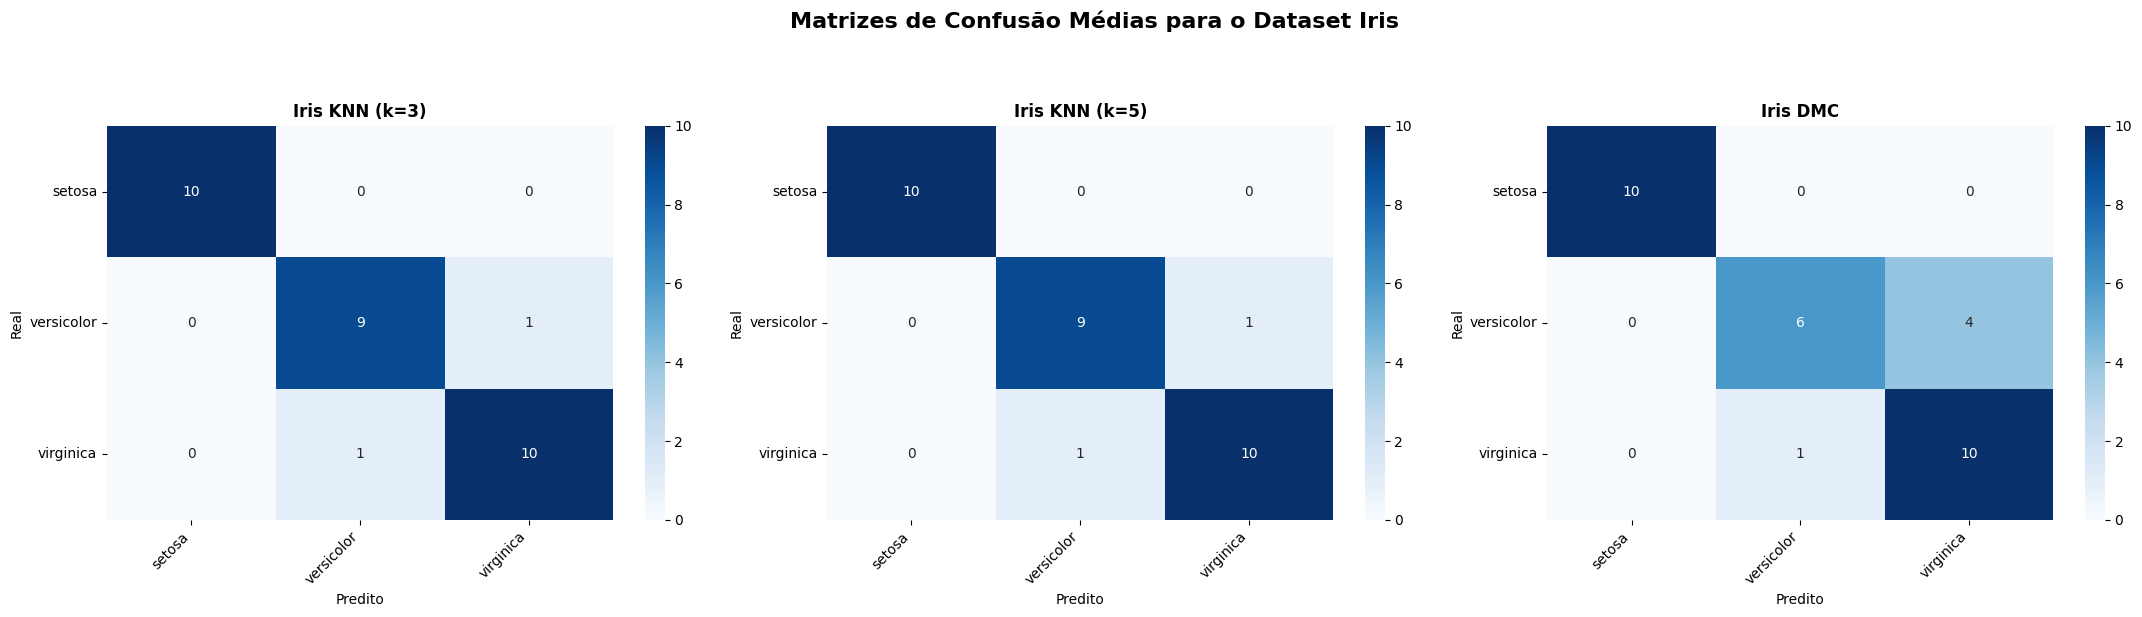

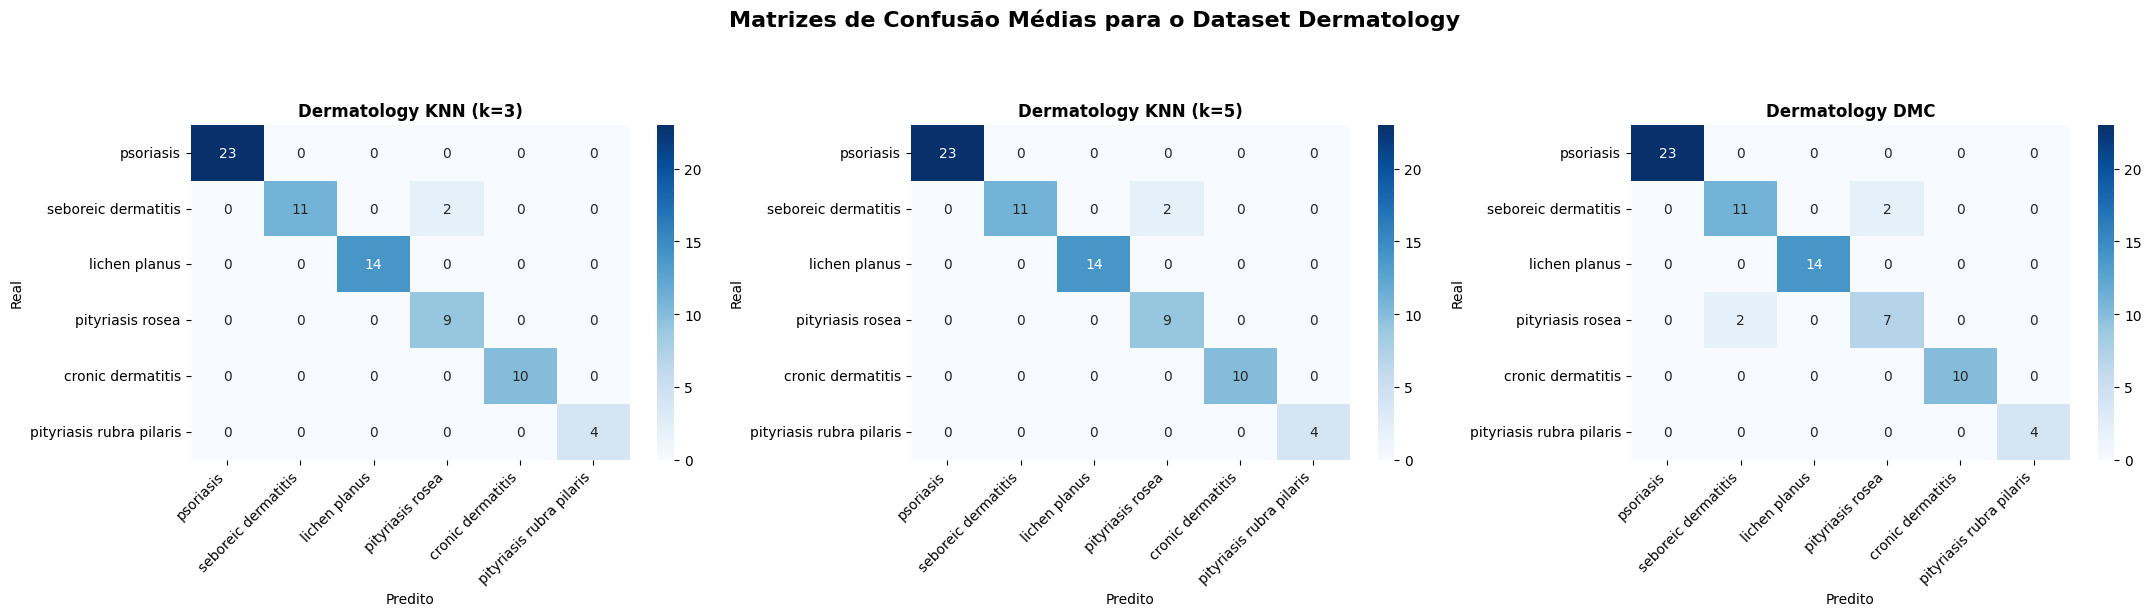

In [95]:
def plot_confusion_matrix(conf_matrix, title, class_names, ax):
  conf_matrix_int = np.round(conf_matrix).astype(int)
  sn.heatmap(conf_matrix_int, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=True,
             xticklabels=class_names, yticklabels=class_names)
  ax.set_title(title, fontsize=12, weight='bold')
  ax.set_xlabel("Predito", fontsize=10)
  ax.set_ylabel("Real", fontsize=10)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


fig, axes = plt.subplots(1, 3, figsize=(22, 6))

plot_confusion_matrix(iris_knn_3_mean_conf_matrix, "Iris KNN (k=3)", iris_class_names, axes[0])
plot_confusion_matrix(iris_knn_5_mean_conf_matrix, "Iris KNN (k=5)", iris_class_names, axes[1])
plot_confusion_matrix(iris_dmc_mean_conf_matrix, "Iris DMC", iris_class_names, axes[2])

plt.suptitle("Matrizes de Confusão Médias para o Dataset Iris", y=1.02, fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

plot_confusion_matrix(dermatology_knn_3_mean_conf_matrix, "Dermatology KNN (k=3)", dermatology_class_names, axes[0])
plot_confusion_matrix(dermatology_knn_5_mean_conf_matrix, "Dermatology KNN (k=5)", dermatology_class_names, axes[1])
plot_confusion_matrix(dermatology_dmc_mean_conf_matrix, "Dermatology DMC", dermatology_class_names, axes[2])

plt.suptitle("Matrizes de Confusão Médias para o Dataset Dermatology", y=1.02, fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()